# Notebook demonstrating fitting of $hrz0$ to site data
The below code shows how to use data from fixed-tilt experiments to compute the free parameter $hrz0$. The dust distribution is currently assumed and its parameters are defined in the file `parameters_qut_experiments.xlsx`.

In [1]:
import numpy as np
import soiling_model.base_models as smb
import soiling_model.fitting as smf
import soiling_model.utilities as smu
from matplotlib import rcParams
import pickle
from scipy.stats import norm
rcParams['figure.figsize'] = (10, 7)
# %matplotlib qt

sp_save_file = "results/sp_fitting_results"
cm_save_file = "results/cm_fitting_results"
reflectometer_angle = 15 # angle of incidence of reflectometer
k_factor = 2.404 # calibration factor for TSP measurements in experiments
second_surf = True # True if using the second-surface model. Otherwise, use first-surface
d = "data/public/qut_experiments/"
files = [   'experiment_20170807_20170811_cinque.xlsx','experiment_20170828_20170901_cinque.xlsx',\
            'experiment_20170905_20170913_cinque.xlsx','experiment_20170915_20170921_cinque.xlsx']
training_intervals = [  np.array(['2017-08-07T00:00:00','2017-08-13T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-08-28T00:00:00','2017-08-31T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-09-05T00:00:00','2017-09-11T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-09-15T00:00:00','2017-09-19T00:00:00'],dtype=np.datetime64)]
parameter_file = d+"parameters_qut_experiments.xlsx"

## Multiple experiment fitting example

In [2]:
train_experiments = [0,1] # indices for training experiments from 0 to len(files)
train_mirrors = ["Mirror_1","Mirror_2","Mirror_3","Mirror_4"] # which mirrors within the experiments are used for training
all_mirrors = ["Mirror_"+str(i+1) for i in range(5)]

files_experiment = [d+files[ii] for ii in range(len(files))]
Nfiles = len(files_experiment)
k_factors = [k_factor]*Nfiles
incidence_angle = [15.0]*Nfiles
dust_types = ["TSP"]*Nfiles

extract = lambda x,ind: [x[ii] for ii in ind]
files_experiment_train = extract(files_experiment,train_experiments)
k_factors_train = extract(k_factors,train_experiments)
dust_types_train = extract(dust_types,train_experiments)
incidence_angle_train = extract(incidence_angle,train_experiments)
t = [t+1 for t in train_experiments]
training_string = "Training: "+str(train_mirrors)+", Exp: "+str(t)

imodel = smf.semi_physical(parameter_file)
sim_data_train = smb.simulation_inputs( files_experiment_train,
                                        k_factors=k_factors_train,
                                        dust_types=dust_types_train
                                        )
reflect_data_train = smb.reflectance_measurements(  files_experiment_train,
                                                    sim_data_train.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=incidence_angle_train,
                                                    import_tilts=True,
                                                    column_names_to_import=train_mirrors
                                                    )
            
sim_data_train,reflect_data_train = smu.trim_experiment_data(sim_data_train,reflect_data_train,training_intervals)

sim_data_total = smb.simulation_inputs( files_experiment,
                                        k_factors=k_factors,
                                        dust_types=dust_types
                                        )
reflect_data_total = smb.reflectance_measurements(  files_experiment,
                                                    sim_data_total.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=incidence_angle,
                                                    import_tilts=True,
                                                    column_names_to_import=None
                                                    )


Importing constants
Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 96 hours
Length of simulation for file data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing dust properties for each experiment
Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_

Text(0.5, 0.98, 'Training Data for file experiment_20170807_20170811_cinque.xlsx')

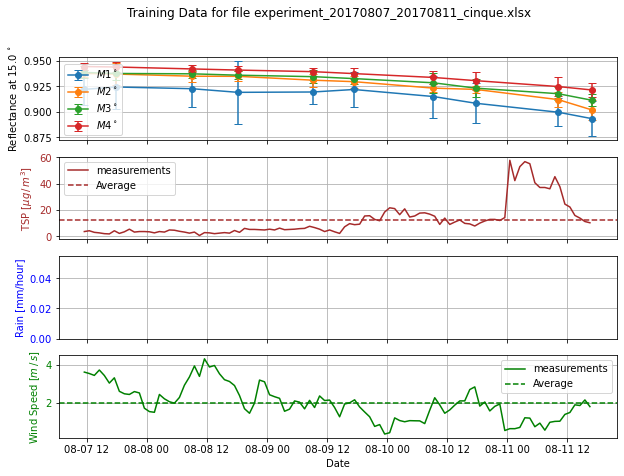

In [3]:
experiment = 0
fig,ax = smu.plot_experiment_data(sim_data_train,reflect_data_train,experiment)
fig.suptitle(f"Training Data for file {files[experiment]}")

Fitting. Use training data only.

In [4]:
imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
hrz0_multi,sse_multi = imodel.fit_hrz0_least_squares(sim_data_train,reflect_data_train)
imodel.update_model_parameters(hrz0_multi)

Setting tilts for 2 experiments
Second surface model
Second surface model
Fitting hrz0 with least squares ...
... done! 
 hrz0 = 3.040141268784892


Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model
No value for hrz0 supplied. Using value in self.hrz0 = 3.040141268784892.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


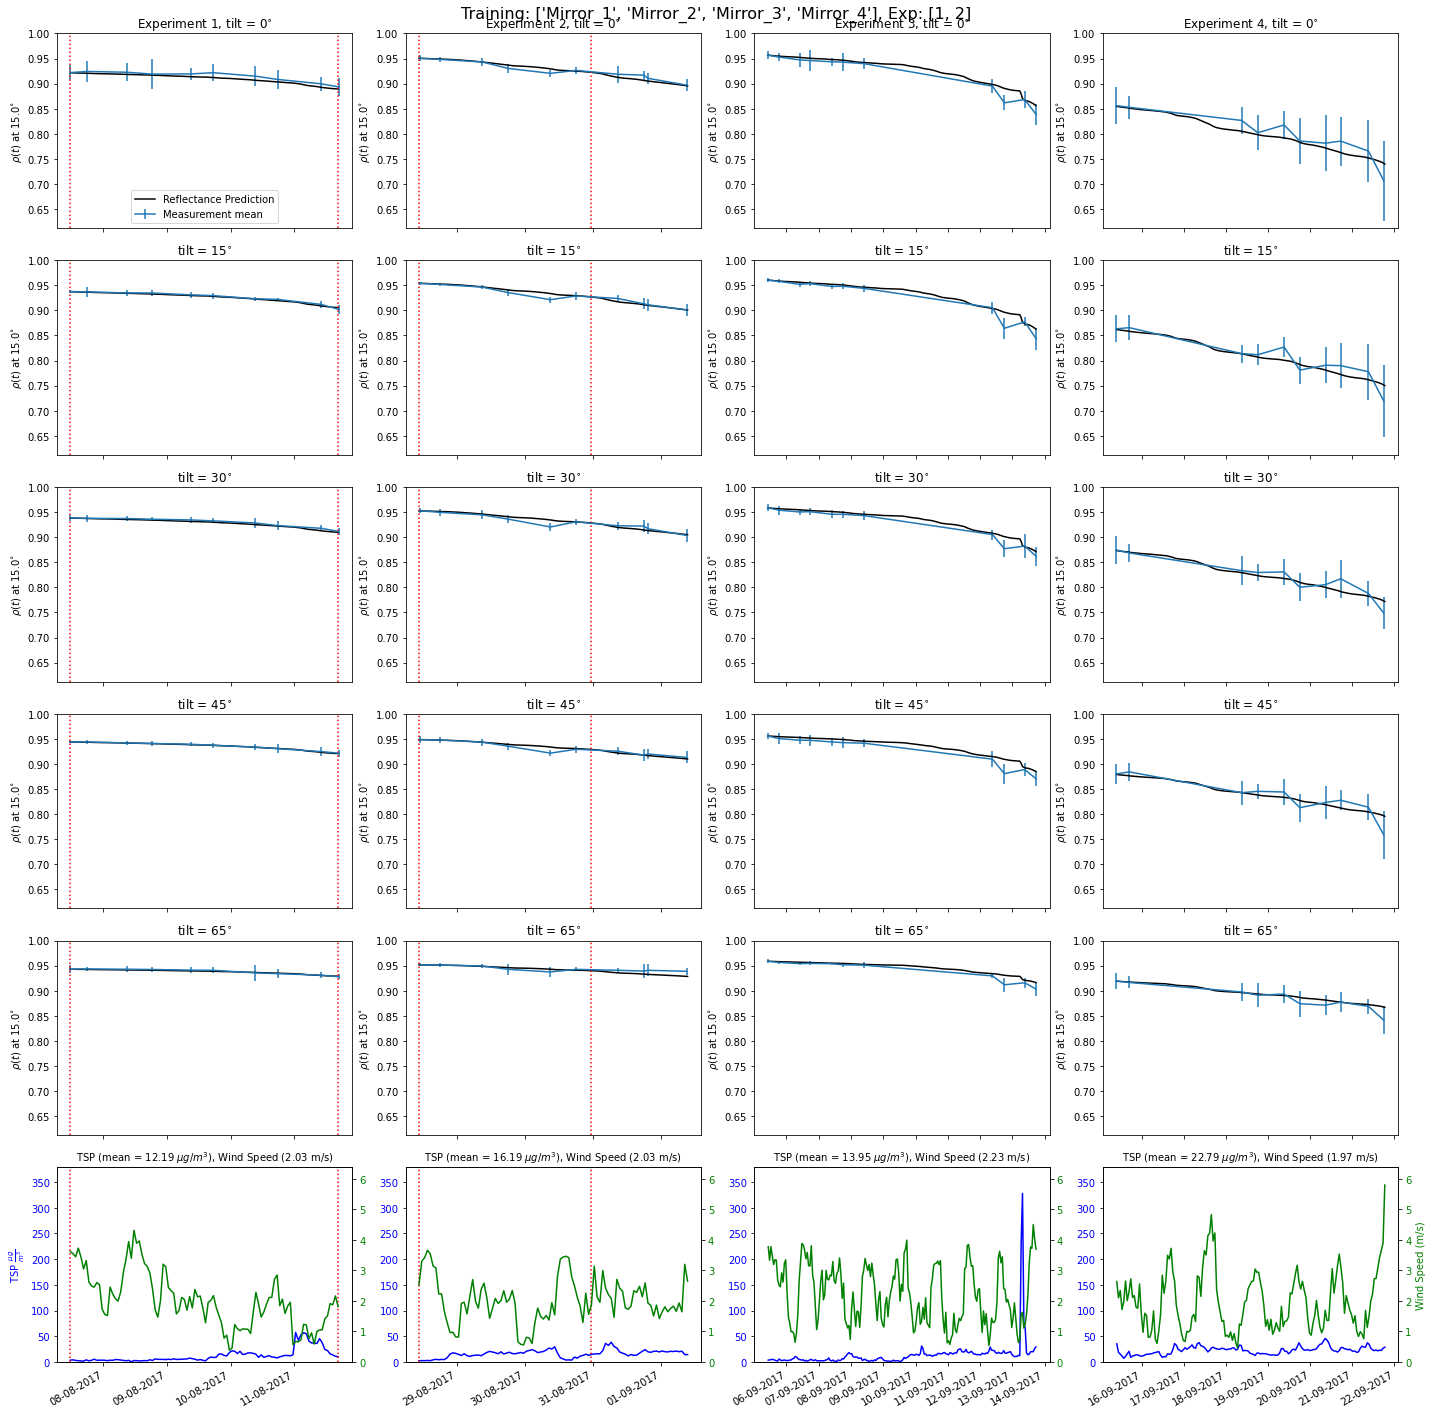

In [5]:
imodel.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)
imodel.predict_reflectance(sim_data_total)
fig,ax,_,_,_  = imodel.plot_soiling_factor( sim_data_total,
                                            reflectance_data=reflect_data_total,
                                            figsize=(20,20),
                                            reflectance_std='measurements',
                                            fig_title=training_string,
                                            return_handles=True);
for e in sim_data_train.time.keys():
    for a in ax[:,e]:
        a.axvline(x=sim_data_train.time[e][0],ls=':',color='red')
        a.axvline(x=sim_data_train.time[e][-1],ls=':',color='red')

# Parameter Estimation for the Stochastic Model
Methods for estimation include:
* Maximum Likelihood Estmation (MLE) or Maximum *A Posteriori* (MAP) of semi-physical model
* MLE/MAP of a constant mean deposition velocity model

## Semi-physical model 
Fit with either MAP or MLE:

Setting tilts for 2 experiments
Second surface model
Second surface model
Getting inital hrz0 guess via least squares
Getting inital sigma_dep guess via MLE (at least-squares hrz0)
x0 = [3.040141268784892, 0.0003246917835281733]
Maximizing likelihood to obtain hrz0 and sigma_dep...
  Optimization terminated successfully.
Estimating parameter covariance using numerical approximation of Hessian ... 
... done! 
hrz0 = 3.18e+00, sigma_dep = 3.23e-04
95% confidence interval for hrz0: [2.10e+00, 4.25e+00]
95% confidence interval for sigma_dep: [2.44e-04, 4.02e-04]
No value for hrz0 supplied. Using value in self.hrz0 = 3.1783083972526187.
Calculating deposition velocity for each of the 2 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This m

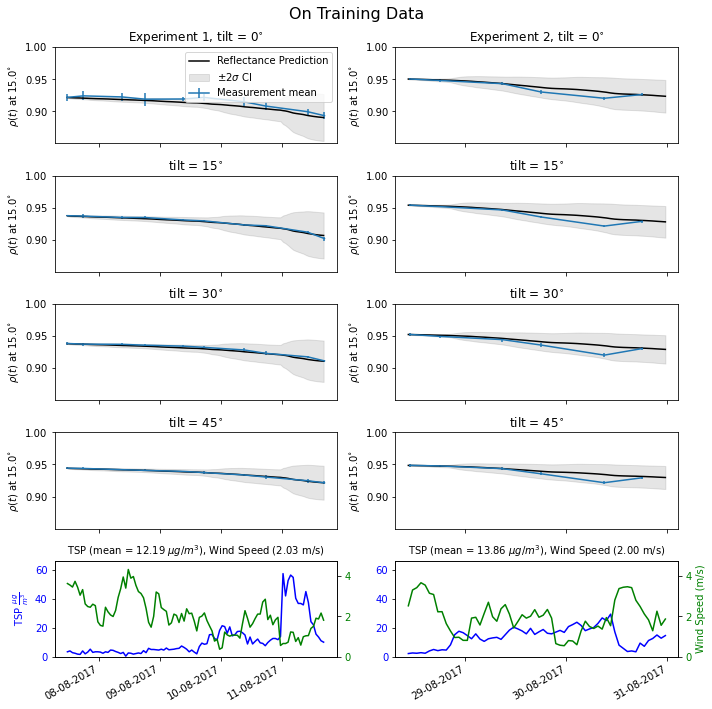

In [6]:
imodel.helios_angles(   sim_data_train,
                        reflect_data_train,
                        second_surface=second_surf)

param_hat,param_cov = imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=True    )

# MAP Fitting
# sigma_h = np.log(np.log(10.0))
# mu_h = np.log(np.log(2.0))
# sigma_sigma_dep = 3.0
# mu_sigma_dep = -5.0
# priors =    {   'log_log_hrz0': norm(scale=sigma_h,loc=mu_h),\
#                 'log_sigma_dep': norm(scale=sigma_sigma_dep,loc=mu_sigma_dep)\
#             }
# param_hat,param_cov = imodel.fit_map(   sim_data_train,
#                                         reflect_data_train,
#                                         priors,verbose=True,
#                                         transform_to_original_scale=True)


s = np.sqrt(np.diag(param_cov))
param_ci = param_hat + 1.96*s*np.array([[-1],[1]])
hrz0_mle,sigma_dep_mle = param_hat
imodel.update_model_parameters(param_hat)
imodel.predict_reflectance(sim_data_train) # writes output into imodel.helios.soiling_factor
imodel.plot_soiling_factor( sim_data_train,
                            reflectance_data=reflect_data_train,
                            figsize=(10,10),
                            reflectance_std='mean',
                            save_path="results/",
                            fig_title="On Training Data"    );

Next, test on the whole dataset and save results

Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model
No value for hrz0 supplied. Using value in self.hrz0 = 3.1783083972526187.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


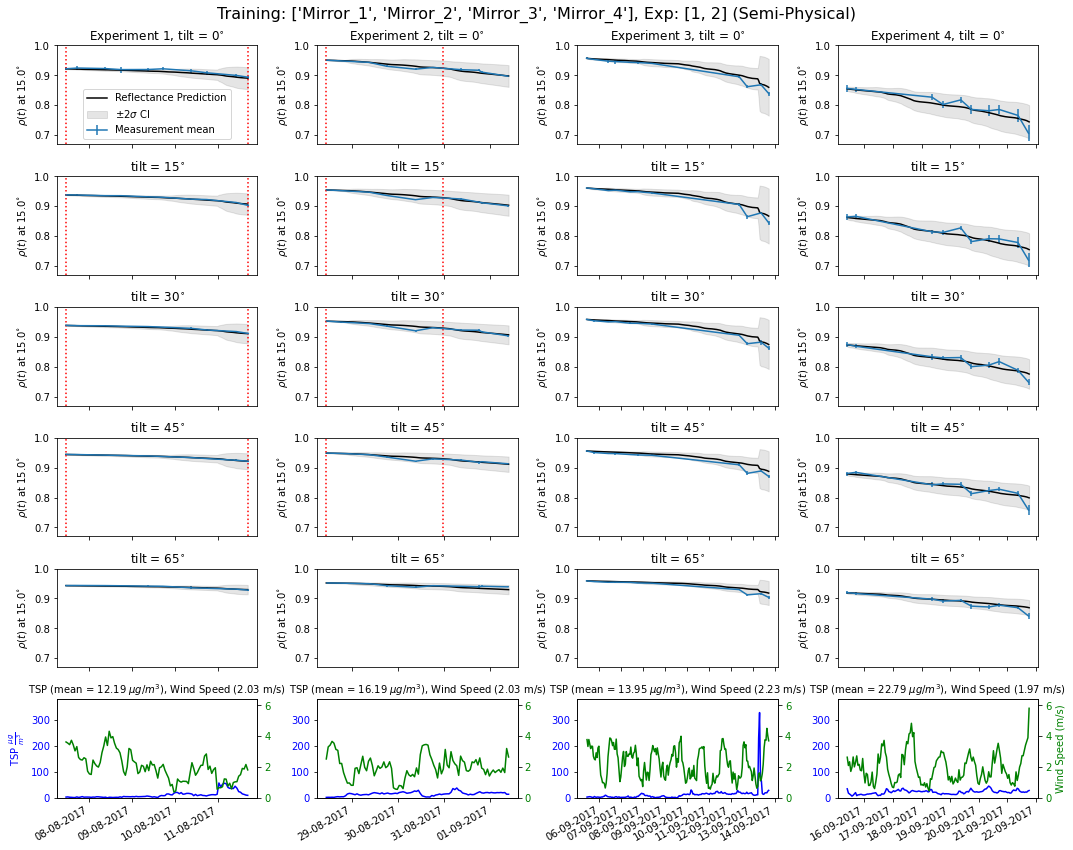

In [7]:
imodel.helios_angles(   sim_data_total,
                        reflect_data_total,
                        second_surface=second_surf)
                        
imodel.predict_reflectance(sim_data_total) # writes output into imodel.helios.soiling_factor
fig_total,ax_total,_,_,_   = imodel.plot_soiling_factor( sim_data_total,
                            reflectance_data=reflect_data_total,
                            figsize=(15,12),
                            reflectance_std='mean',
                            save_path="results/semi_physical_fitting.png",
                            fig_title=training_string+" (Semi-Physical)",
                            return_handles=True);

# add lines indicating training times for mirrors 
# and experiments use for training.
for e in train_experiments:
    for ii,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[ii,e]
            a.axvline(x=sim_data_train.time[e][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[e][-1],ls=':',color='red')

semi_physical_fitting_results = {
    'model':imodel,
    'simulation_data_train':sim_data_train,
    'reflectance_data_train':reflect_data_train,
    'simulation_data_total':sim_data_total,
    'reflectance_data_total':reflect_data_total,
}
with open(sp_save_file,"wb") as fid:
    pickle.dump(semi_physical_fitting_results,fid)

## Constant Mean Desposition Velocity
Again, fit with either MAP or MLE:

Importing constants
Setting tilts for 2 experiments
Second surface model
Second surface model
Getting MLE estimates ... 
========== MLE Estimates ======== 
mu_tilde = 1.01e-04, sigma_dep = 3.12e-04
95% confidence interval for mu_tilde: [-1.13e-03, 1.34e-03]
95% confidence interval for sigma_dep: [-4.48e-03, 5.10e-03]


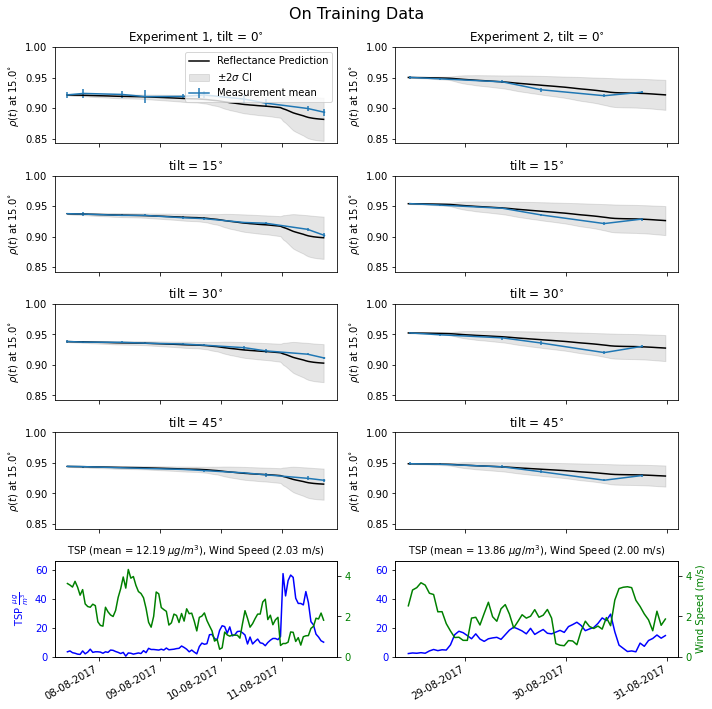

In [8]:
constant_imodel = smf.constant_mean_deposition_velocity(parameter_file)
constant_imodel.helios_angles(   sim_data_train,
                        reflect_data_train,
                        second_surface=second_surf)

param_hat,param_cov = constant_imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=True    )

# MAP Fitting
# sigma_m = 1.5
# mu_m = -10.0
# sigma_sigma_dep = 5.0
# mu_sigma_dep = 0.0
# priors =    {   'log_mu_tilde': norm(scale=sigma_m,loc=mu_m),\
#                 'log_sigma_dep': norm(scale=sigma_sigma_dep,loc=mu_sigma_dep)\
#               }

# param_hat,param_cov = constant_imodel.fit_map(  sim_data_train,
#                                                 reflect_data_train,
#                                                 priors,verbose=True,
#                                                 transform_to_original_scale=True)


s = np.sqrt(np.diag(param_cov))
param_ci = param_hat + 1.96*s*np.array([[-1],[1]])
hrz0_mle,sigma_dep_mle = param_hat
constant_imodel.update_model_parameters(param_hat)
constant_imodel.predict_reflectance(sim_data_train) # writes output into imodel.helios.soiling_factor
constant_imodel.plot_soiling_factor(    sim_data_train,
                                        reflectance_data=reflect_data_train,
                                        figsize=(10,10),
                                        reflectance_std='mean',
                                        save_path="results/",
                                        fig_title="On Training Data"    );

Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


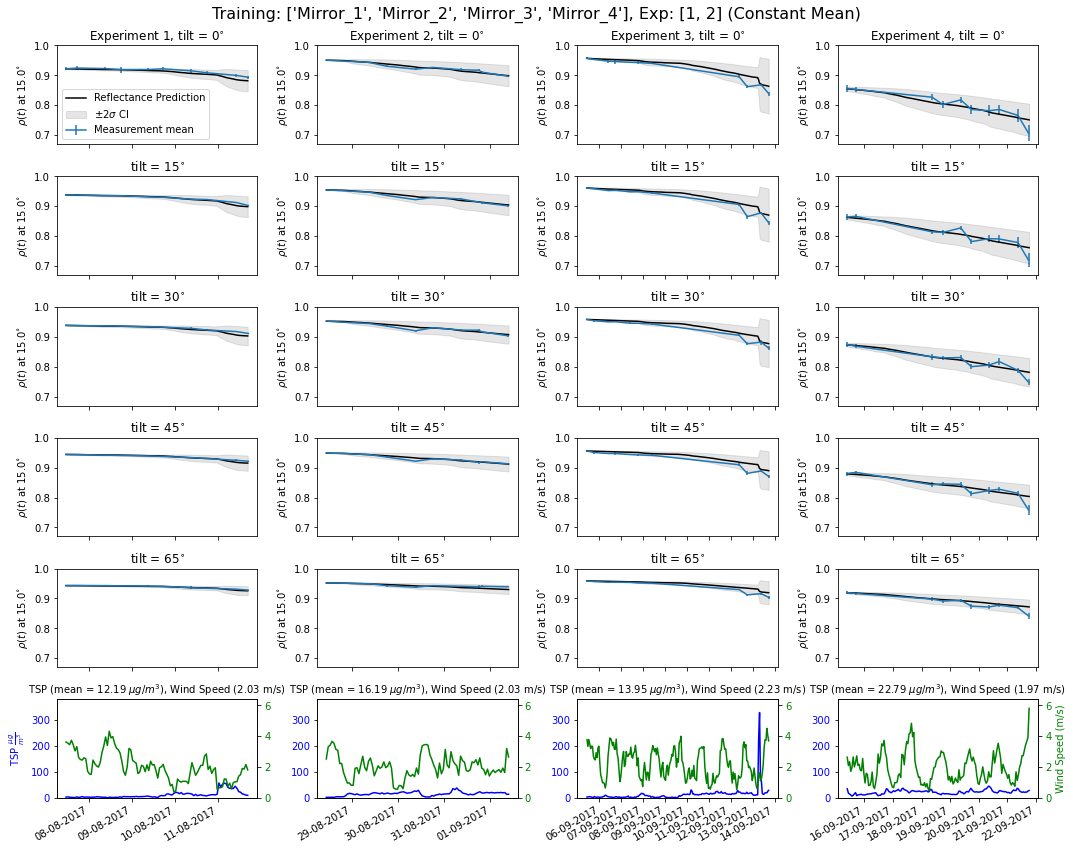

In [9]:
constant_imodel.helios_angles(  sim_data_total,
                                reflect_data_total,
                                second_surface=second_surf)
                        
constant_imodel.predict_reflectance(sim_data_total) # writes output into imodel.helios.soiling_factor
fig_total,ax_total,_,_,_   = constant_imodel.plot_soiling_factor(   sim_data_total,
                                                                    reflectance_data=reflect_data_total,
                                                                    figsize=(15,12),
                                                                    reflectance_std='mean',
                                                                    save_path="results/constant_mean_fitting.png",
                                                                    fig_title=training_string+" (Constant Mean)",
                                                                    return_handles=True);